# Import Packages

In [7]:
import sys

sys.path.append('../')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
from tqdm.notebook import tqdm

In [9]:
from src.evaluation_metrics import (
    max_intra_distance,
    min_inter_distance
)
from src.gaussian_mixture import GMMUtils
from src.merge_components import (
    EntMergeComponents,
    NEnt1MergeComponents,
    DEMPMergeComponents,
    DEMP2MergeComponents,
    MCMergeComponents,
    NMCMergeComponents
)

# Helper Functions

In [10]:
def create_artificial_prob(seed):
    """
    Create unmerged probabilities (prob_0) from the artificial dataset.

    Args:
        seed (int): random seed.
    Returns:
        Tuple[ndarray, ndarray]: X, prob_0.
    """
    random = RandomState(seed)
    K = 50
    D = 2
    rho = random.dirichlet(alpha=np.ones(K) * 1.0)
    means = random.randn(K, D) * 3
    covariances = [np.eye(D) * np.diag(0.5 + random.rand(D)) for k in range(K)]
    gmm = GMMUtils(rho, means, covariances)
    X = gmm.sample(N=5000, random_state=seed)
    prob_0 = gmm.prob_latent(X)
    return X, prob_0

# Artificial Experiment

In [12]:
T = 100  # number of trial
L_list = [40, 30, 20, 10, 5]  # numbers of the components measured the distance

results_intra = np.zeros([6, len(L_list), T])
results_inter = np.zeros([6, len(L_list), T])

for t in tqdm(range(T)):
    X, prob_0 = create_artificial_prob(seed=t + 100)
    algorithm_list = [
        EntMergeComponents(),
        NEnt1MergeComponents(),
        DEMPMergeComponents(),
        DEMP2MergeComponents(),
        MCMergeComponents(),
        NMCMergeComponents()
    ]
    # fit
    for algorithm in algorithm_list:
        algorithm.fit(prob_0)
    # calculate distances
    for i in range(6):
        for j in range(len(L_list)):
            results_intra[i, j, t] = max_intra_distance(X, algorithm_list[i].prob_merged(prob_0, L_list[j]))
            results_inter[i, j, t] = min_inter_distance(X, algorithm_list[i].prob_merged(prob_0, L_list[j]))

# Create Ranking

In [13]:
def rank(a):
    u, cnt = np.unique(a, return_counts=True)
    values = np.cumsum(cnt) - 0.5 * (cnt - 1)
    indices = np.searchsorted(u, a)
    return values[indices]

In [14]:
ranks_intra = np.zeros([6, len(L_list), T])
for j in range(len(L_list)):
    for t in range(T):
        ranks_intra[:, j, t] = rank(results_intra[:, j, t])

print(np.mean(ranks_intra, axis=2))

[[5.99  6.    6.    5.86  5.6  ]
 [2.98  3.73  3.965 4.15  4.245]
 [3.355 3.93  3.68  2.405 2.05 ]
 [3.305 2.705 2.34  2.1   2.03 ]
 [2.79  2.625 3.455 4.66  4.92 ]
 [2.58  2.01  1.56  1.825 2.155]]


In [15]:
ranks_inter = np.zeros([6, len(L_list), T])
for j in range(len(L_list)):
    for t in range(T):
        ranks_inter[:, j, t] = rank(- results_inter[:, j, t])

print(np.mean(ranks_inter, axis=2))

[[4.72  5.18  5.235 5.435 5.195]
 [3.985 3.905 4.285 4.72  3.805]
 [4.58  4.87  4.76  2.825 2.685]
 [3.875 3.655 3.12  2.67  2.585]
 [2.385 2.26  2.52  4.    4.965]
 [1.455 1.13  1.08  1.35  1.765]]


# Plot one trial

In [56]:
alg_name_list = [
    'Ent',
    'Nent1',
    'DEMP',
    'DEMP2',
    'MC',
    'NMC'
]

algorithm_list = [
    EntMergeComponents(),
    NEnt1MergeComponents(),
    DEMPMergeComponents(),
    DEMP2MergeComponents(),
    MCMergeComponents(),
    NMCMergeComponents()
]

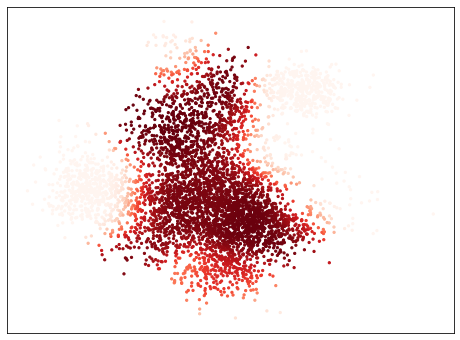

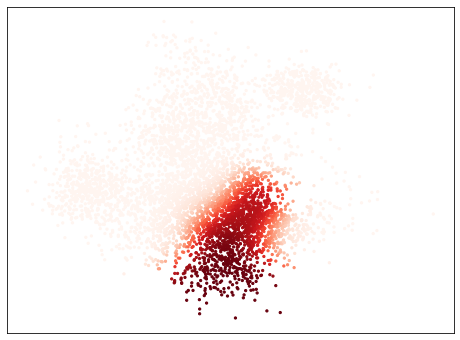

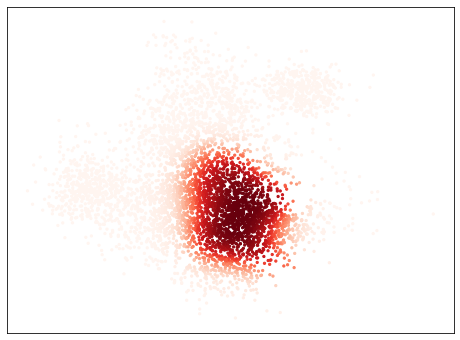

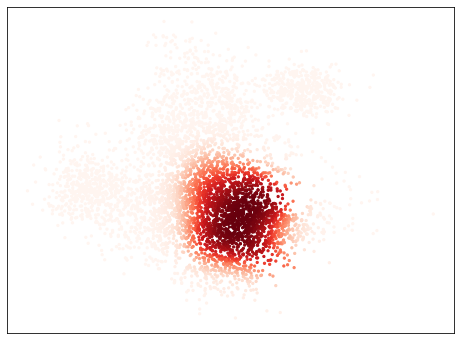

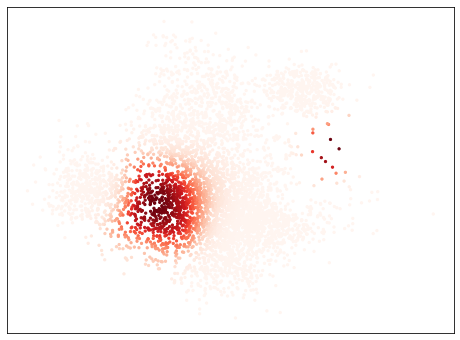

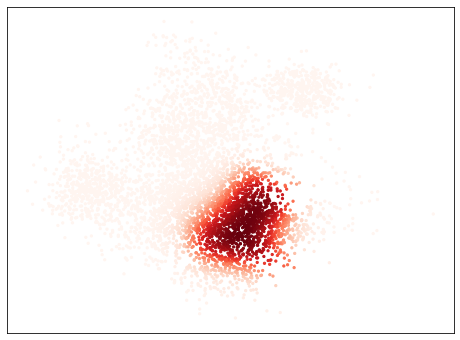

In [62]:
for alg_name, alg in zip(alg_name_list, algorithm_list):
    X, prob_0 = create_artificial_prob(seed=6)
    alg.fit(prob_0)
    prob_merged = alg.prob_merged(prob_0, 20)
    indices = np.argmax(
        prob_merged,
        axis=1
    )
    u, c = np.unique(indices, return_counts=True)
    c_max = u[np.argmax(c)]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.tick_params(
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        bottom=False,
        left=False,
        right=False,
        top=False
    )

    ax.scatter(X[:, 0], X[:, 1], s=5, c=prob_merged[:, c_max], cmap='Reds')
    plt.savefig(f'{alg_name}_20.png')